<a href="https://colab.research.google.com/github/ImrahilAragorn/AML_Satellite_Imagery/blob/main/Satellite_Imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install patchify

In [2]:
!pip install -U segmentation-models

In [3]:

!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6

In [4]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras.models import load_model
import tensorflow as tf
import segmentation_models as sm
from keras import backend as K

Segmentation Models: using `tf.keras` framework.


In [5]:
minmaxscaler = MinMaxScaler()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!ls -lah '/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset'

total 1.2M
-rw------- 1 root root  548 Nov 28 13:31  classes.json
-rw------- 1 root root 1.1M Dec  4 06:17 'Satellite Imagery.ipynb'
drwx------ 4 root root 4.0K Nov 29 09:17 'Tile 1'
drwx------ 4 root root 4.0K Nov 29 09:17 'Tile 2'
drwx------ 4 root root 4.0K Nov 29 09:17 'Tile 3'
drwx------ 4 root root 4.0K Nov 29 09:17 'Tile 4'
drwx------ 4 root root 4.0K Nov 29 09:17 'Tile 5'
drwx------ 4 root root 4.0K Nov 29 09:17 'Tile 6'
drwx------ 4 root root 4.0K Nov 29 09:17 'Tile 7'
drwx------ 4 root root 4.0K Nov 29 09:17 'Tile 8'


In [8]:
dataset_root_folder = '/content/drive/MyDrive/Colab Notebooks/datasets/satellite/'

In [9]:
dataset_name= 'DubaiDataset'

In [10]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  #print(dir_name)
  if dir_name == 'masks' : #' images
    images= os.listdir(path)
    print(path)
    #print(images)
    for i, image_name in enumerate(images):
      if (image_name.endswith('.png')): # '.jpg
       #print(image_name)
       a = True

/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset/Tile 4/masks
/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset/Tile 2/masks
/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset/Tile 5/masks
/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset/Tile 8/masks
/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset/Tile 1/masks
/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset/Tile 6/masks
/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset/Tile 3/masks
/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset/Tile 7/masks


In [11]:
image_patch_size= 256

In [12]:
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 1/images/image_part_001.jpg',1)

In [13]:
image_patches = patchify( image, (image_patch_size, image_patch_size, 3) , step=image_patch_size)

In [14]:
image_patches

array([[[[[[201, 195, 190],
           [225, 219, 214],
           [241, 232, 228],
           ...,
           [228, 219, 210],
           [219, 212, 203],
           [224, 217, 208]],

          [[226, 220, 215],
           [254, 248, 243],
           [255, 255, 251],
           ...,
           [238, 229, 220],
           [237, 230, 221],
           [243, 234, 225]],

          [[248, 241, 238],
           [255, 252, 249],
           [255, 255, 251],
           ...,
           [238, 228, 221],
           [235, 228, 219],
           [230, 221, 212]],

          ...,

          [[225, 220, 221],
           [209, 205, 204],
           [188, 187, 183],
           ...,
           [185, 174, 184],
           [218, 210, 221],
           [173, 168, 177]],

          [[196, 192, 191],
           [202, 198, 197],
           [221, 220, 216],
           ...,
           [137, 127, 139],
           [170, 163, 176],
           [171, 166, 175]],

          [[193, 188, 185],
           [201, 198, 194]

In [15]:
image_x= image_patches[0,0,:,:]

#MinMaxScaler

image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)

In [16]:
image_y.shape

(1, 256, 256, 3)

In [17]:
print(type(image))

<class 'numpy.ndarray'>


In [18]:
type(Image.fromarray(image))

PIL.Image.Image

In [19]:
image.shape

(644, 797, 3)

In [20]:

image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

In [21]:

print(len(image_dataset))
print(len(mask_dataset))

945
945


In [22]:

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [23]:

print(len(image_dataset))
print(len(mask_dataset))

945
945


In [24]:
import matplotlib.pyplot as plt

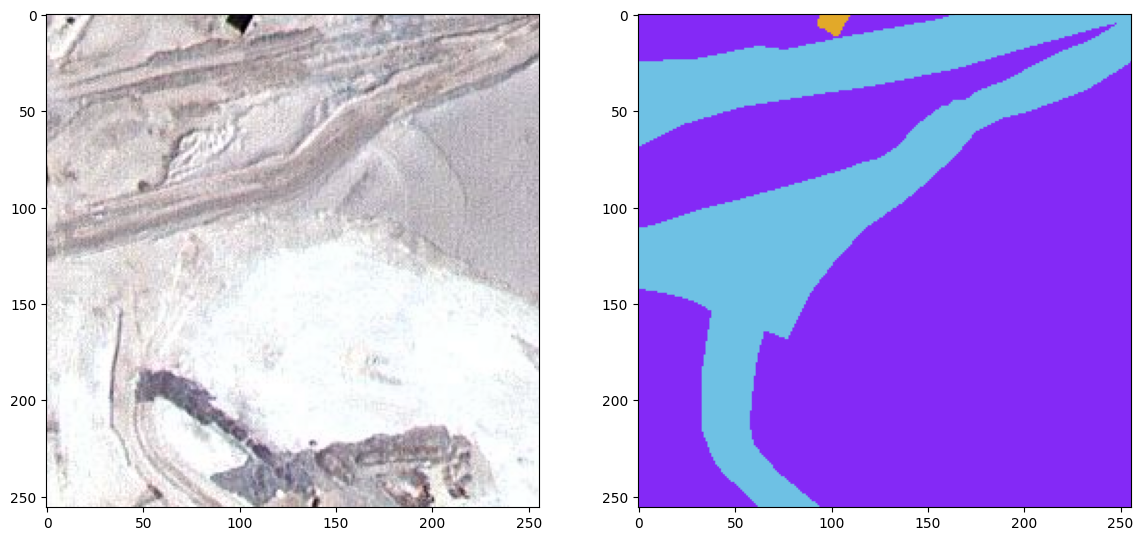

In [25]:

random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [26]:

class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [27]:
label = individual_patched_mask

In [28]:

def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment


In [29]:

labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [30]:

print(len(labels))

945


In [31]:

labels = np.array(labels)

In [32]:

labels[3]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [33]:
labels = np.expand_dims(labels, axis=3)

In [34]:


np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

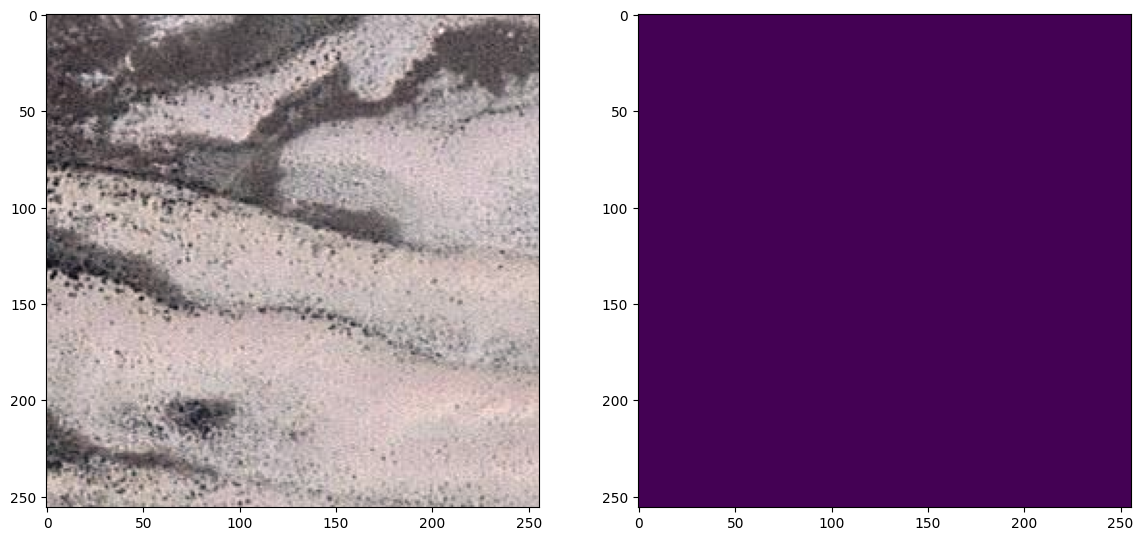

In [35]:

random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [36]:
total_classes = len(np.unique(labels))

In [37]:
total_classes

6

In [38]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [39]:

labels_categorical_dataset.shape

(945, 256, 256, 6)

In [40]:

master_trianing_dataset = image_dataset

In [41]:

master_trianing_dataset.shape

(945, 256, 256, 3)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)



In [43]:

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [44]:

image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [45]:

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [46]:

def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [47]:

def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [48]:
metrics = ["accuracy", jaccard_coef]

In [49]:

def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [50]:

model = get_deep_learning_model()

In [51]:
model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'registered_name': None,
   'name': 'input_1',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': N

In [52]:

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [53]:

dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [54]:

focal_loss = sm.losses.CategoricalFocalLoss()

In [55]:
total_loss = dice_loss + (1 * focal_loss)

In [56]:

tf.keras.backend.clear_session()

In [57]:

model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [58]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [59]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=1,
                          validation_data=(X_test, y_test),
                          shuffle=False)

51/51 [==============================] - 593s 12s/step - loss: 1.0007 - accuracy: 0.5280 - jaccard_coef: 0.2620 - val_loss: 0.9815 - val_accuracy: 0.6497 - val_jaccard_coef: 0.3608


In [60]:
history_a = model_history

In [61]:

history_a.history

{'loss': [1.0007277727127075],
 'accuracy': [0.5280448198318481],
 'jaccard_coef': [0.26195618510246277],
 'val_loss': [0.9815462231636047],
 'val_accuracy': [0.6496680974960327],
 'val_jaccard_coef': [0.3608045279979706]}

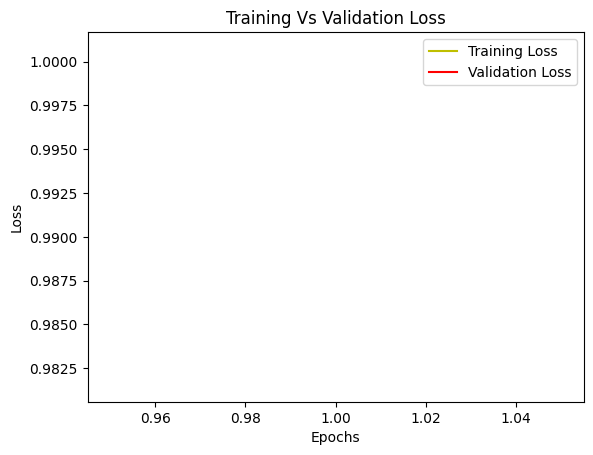

In [62]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

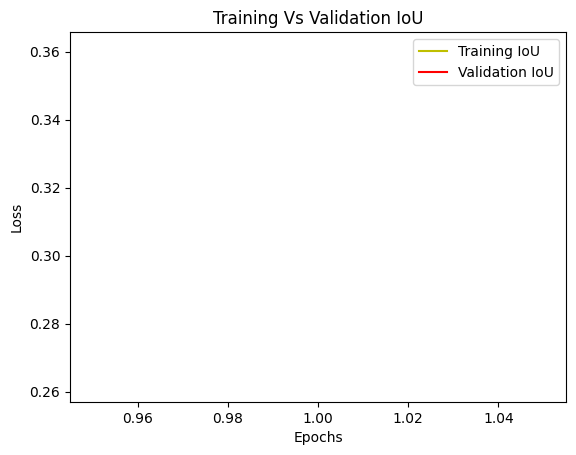

In [63]:

jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [64]:
model_history.params


{'verbose': 1, 'epochs': 1, 'steps': 51}

In [65]:
y_pred = model.predict(X_test)

5/5 [==============================] - 24s 5s/step


In [66]:

len(y_pred)

142

In [67]:

y_pred

array([[[[0.19495554, 0.19378367, 0.17721912, 0.16280395, 0.15489006,
          0.11634764],
         [0.18582627, 0.23785344, 0.18360507, 0.1495478 , 0.15876077,
          0.08440666],
         [0.19965203, 0.23939462, 0.18889195, 0.14481145, 0.15587716,
          0.07137281],
         ...,
         [0.22625957, 0.19025195, 0.18562618, 0.1421906 , 0.16302696,
          0.09264483],
         [0.20203379, 0.1851918 , 0.16777748, 0.14594024, 0.1881791 ,
          0.11087761],
         [0.18416514, 0.18094344, 0.15786475, 0.151832  , 0.19278468,
          0.13240997]],

        [[0.16861854, 0.22514719, 0.16629447, 0.15136802, 0.18512313,
          0.10344855],
         [0.1917308 , 0.24293123, 0.19235232, 0.14482334, 0.15166901,
          0.07649323],
         [0.2095037 , 0.24991995, 0.2042287 , 0.12983604, 0.14780936,
          0.05870226],
         ...,
         [0.23869932, 0.202562  , 0.19438015, 0.13764574, 0.15100433,
          0.07570839],
         [0.20576346, 0.2161508 , 0.1784

In [68]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [69]:

len(y_pred_argmax)

142

In [70]:

y_pred_argmax

array([[[0, 1, 1, ..., 0, 0, 4],
        [1, 1, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [2, 0, 0, ..., 1, 1, 1],
        [2, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 2]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        ...,
        [2, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 4],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 2, 1, ..., 2, 2, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [2, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [71]:

y_test_argmax = np.argmax(y_test, axis=3)

In [72]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [73]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 155ms/step


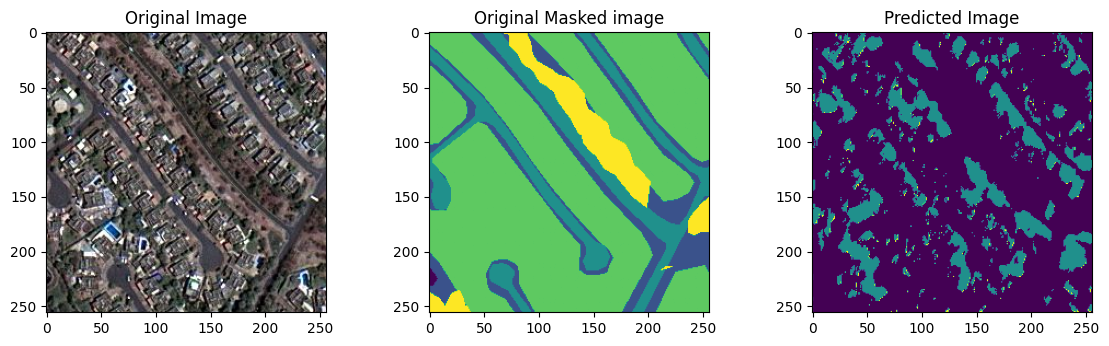

In [74]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [75]:
model.save("satellite_segmentation_full.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [76]:
!ls -lah

total 23M
drwxr-xr-x 1 root root 4.0K Dec  4 06:30 .
drwxr-xr-x 1 root root 4.0K Dec  4 06:14 ..
drwxr-xr-x 4 root root 4.0K Nov 30 14:24 .config
drwx------ 5 root root 4.0K Dec  4 06:15 drive
drwxr-xr-x 1 root root 4.0K Nov 30 14:27 sample_data
-rw-r--r-- 1 root root  23M Dec  4 06:30 satellite_segmentation_full.h5


In [80]:
saved_model = load_model('/content/satellite_segmentation_full.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

In [81]:
model.loss.name

'dice_loss_plus_1focal_loss'

In [82]:
saved_model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'registered_name': None,
   'name': 'input_1',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': N

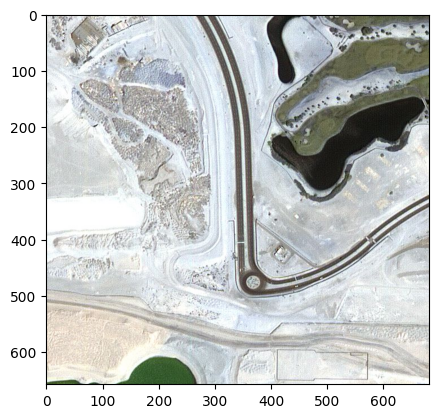

In [92]:
plt.imshow(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset/Tile 3/images/image_part_006.jpg'))

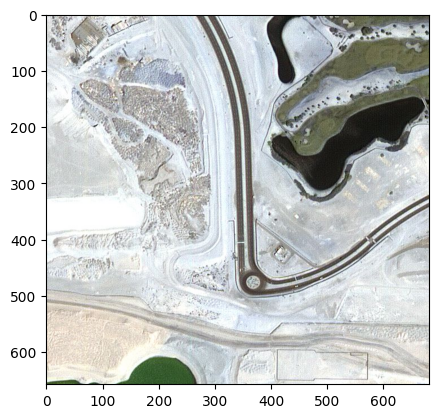

In [94]:
plt.imshow(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset/Tile 3/images/image_part_006.jpg'))

In [95]:
image = Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset/Tile 3/images/image_part_006.jpg')
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image, 0)

In [96]:
prediction = saved_model.predict(image)

1/1 [==============================] - 0s 387ms/step


In [97]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

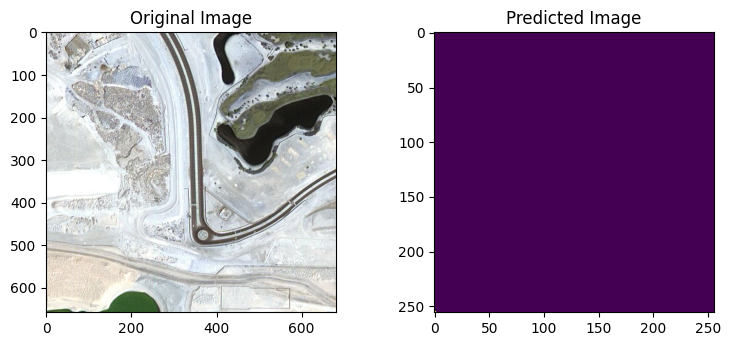

In [99]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/satellite/DubaiDataset/Tile 3/images/image_part_006.jpg'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)